<a href="https://colab.research.google.com/github/kimhwidam/Deep-Learning/blob/main/DL_2%EC%9D%BC%EC%B0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DL 2일차 - Mask man Classification

데이터 출처 - https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset

In [6]:
# 마운트해서 드라이브에 있는 파일 압축
import zipfile

content_zip = zipfile.ZipFile('./drive/MyDrive/archive (2).zip')
content_zip.extractall('./drive/MyDrive')
content_zip.close()

In [7]:
# 모듈 임포트
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import Sequential, models
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [10]:
# 파일 정리
path = './drive/MyDrive/Face Mask Dataset/'
dataset = {
    'image_path': [],
    'mask_status': [],
    'where': []
}

for where in os.listdir(path):
    print('Where --> : ', where)
    for status in os.listdir(path + '/' + where):
        print('\tStatus --> : ', status)
        for image in glob.glob(path + where + '/' + status + '/' + '*.png'):
            dataset['image_path'].append(image)
            dataset['mask_status'].append(status)
            dataset['where'].append(where)


Where --> :  Test
	Status --> :  WithMask
	Status --> :  WithoutMask
Where --> :  Train
	Status --> :  WithMask
	Status --> :  WithoutMask
Where --> :  Validation
	Status --> :  WithMask
	Status --> :  WithoutMask


In [11]:
# 정리한 파일을 데이터프레임으로 저
dataset = pd.DataFrame(dataset)
dataset

,image_path,mask_status,where
0,./drive/MyDrive/Face Mask Dataset/Test/WithMas...,WithMask,Test
1,./drive/MyDrive/Face Mask Dataset/Test/WithMas...,WithMask,Test
2,./drive/MyDrive/Face Mask Dataset/Test/WithMas...,WithMask,Test
3,./drive/MyDrive/Face Mask Dataset/Test/WithMas...,WithMask,Test
4,./drive/MyDrive/Face Mask Dataset/Test/WithMas...,WithMask,Test
...,...,...,...
11787,./drive/MyDrive/Face Mask Dataset/Validation/W...,WithoutMask,Validation
11788,./drive/MyDrive/Face Mask Dataset/Validation/W...,WithoutMask,Validation
11789,./drive/MyDrive/Face Mask Dataset/Validation/W...,WithoutMask,Validation
11790,./drive/MyDrive/Face Mask Dataset/Validation/W...,WithoutMask,Validation


With Mask 5909
Without Mask 5883


<Axes: xlabel='mask_status', ylabel='count'>

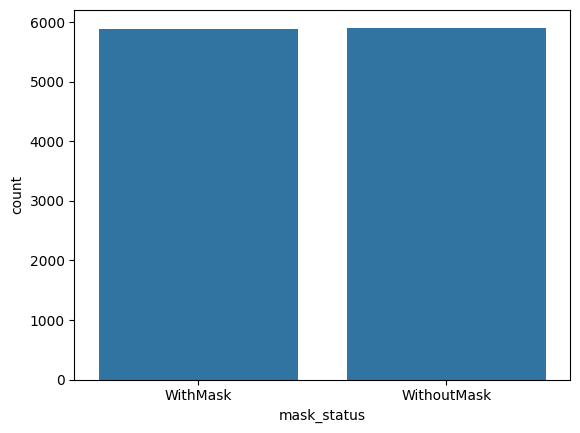

In [12]:
# 간단한 확인 위해 EDA 시각화
print('With Mask', dataset.value_counts('mask_status')[0])
print('Without Mask', dataset.value_counts('mask_status')[1])
sns.countplot(x=dataset['mask_status'])

고르게 잘 들어가있음

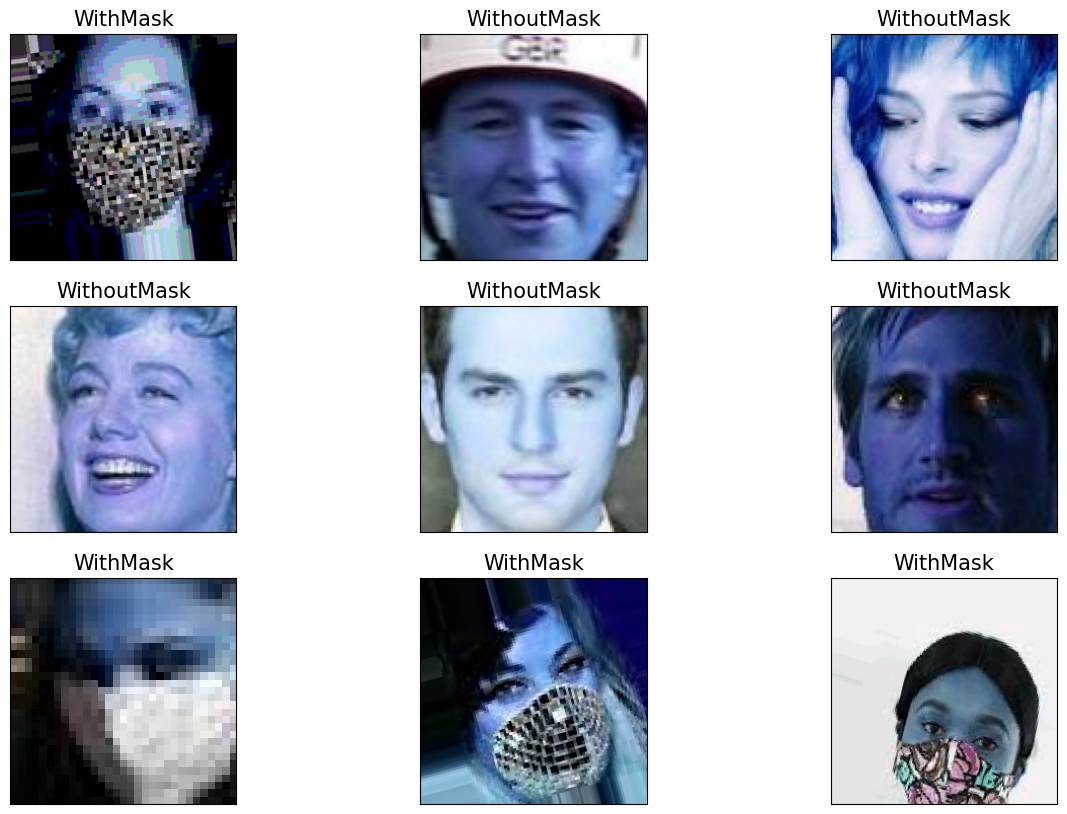

In [15]:
# 랜덤하게 어떤 그림들이 있는지 확인
import cv2

plt.figure(figsize=(15,10))
for i in range(9):
    random = np.random.randint(1, len(dataset))
    plt.subplot(3, 3, i+1)
    plt.imshow(cv2.imread(dataset.loc[random, 'image_path']))
    plt.title(dataset.loc[random, 'mask_status'], size=15)
    plt.xticks([])
    plt.yticks([])
plt.show()

train, test, validation으로 나눌 필요가 없긴 한데 연습 차원으로 나누자

In [16]:
train_df = dataset[dataset['where'] == 'Train']
test_df = dataset[dataset['where'] == 'Test']
validation_df = dataset[dataset['where'] == 'Validation']

train_df.head()

,image_path,mask_status,where
992,./drive/MyDrive/Face Mask Dataset/Train/WithMa...,WithMask,Train
993,./drive/MyDrive/Face Mask Dataset/Train/WithMa...,WithMask,Train
994,./drive/MyDrive/Face Mask Dataset/Train/WithMa...,WithMask,Train
995,./drive/MyDrive/Face Mask Dataset/Train/WithMa...,WithMask,Train
996,./drive/MyDrive/Face Mask Dataset/Train/WithMa...,WithMask,Train


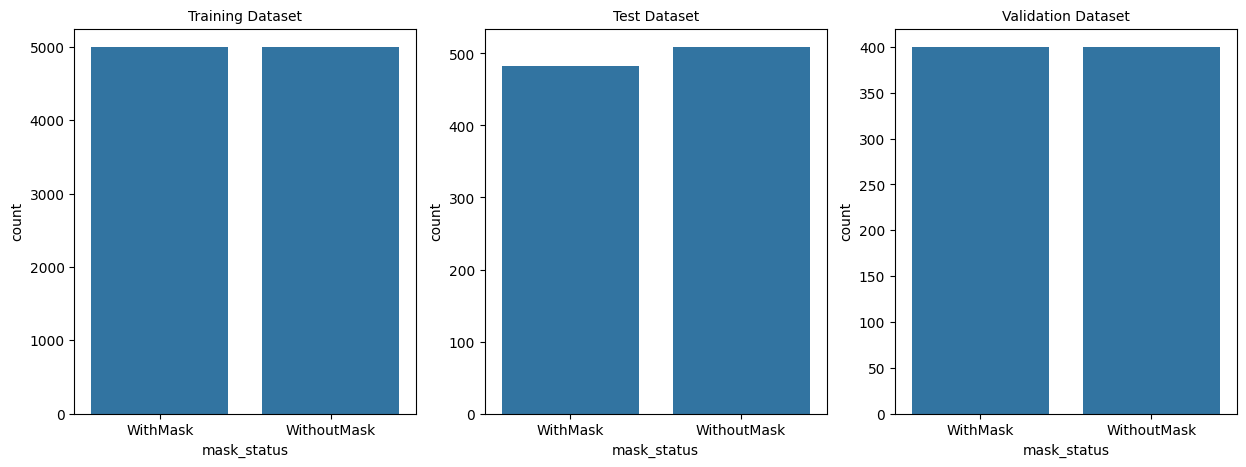

In [18]:
# 잘 나눠졌는지 확인
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sns.countplot(x=train_df['mask_status'])
plt.title('Training Dataset', size=10)

plt.subplot(1,3,2)
sns.countplot(x=test_df['mask_status'])
plt.title('Test Dataset', size=10)

plt.subplot(1,3,3)
sns.countplot(x=validation_df['mask_status'])
plt.title('Validation Dataset', size=10)

plt.show()

In [19]:
# 인덱스 초기화
train_df = train_df.reset_index(drop=True)
train_df

,image_path,mask_status,where
0,./drive/MyDrive/Face Mask Dataset/Train/WithMa...,WithMask,Train
1,./drive/MyDrive/Face Mask Dataset/Train/WithMa...,WithMask,Train
2,./drive/MyDrive/Face Mask Dataset/Train/WithMa...,WithMask,Train
3,./drive/MyDrive/Face Mask Dataset/Train/WithMa...,WithMask,Train
4,./drive/MyDrive/Face Mask Dataset/Train/WithMa...,WithMask,Train
...,...,...,...
9995,./drive/MyDrive/Face Mask Dataset/Train/Withou...,WithoutMask,Train
9996,./drive/MyDrive/Face Mask Dataset/Train/Withou...,WithoutMask,Train
9997,./drive/MyDrive/Face Mask Dataset/Train/Withou...,WithoutMask,Train
9998,./drive/MyDrive/Face Mask Dataset/Train/Withou...,WithoutMask,Train


In [20]:
# 데이터 전처리
data = []
image_size = 150

for i in range(len(train_df)):
    img_array = cv2.imread(train_df['image_path'][i], cv2.IMREAD_GRAYSCALE)
    new_image_array = cv2.resize(img_array, (image_size, image_size))

    if train_df['mask_status'][i] == 'WithMask':
        data.append([new_image_array, 1])
    else:
        data.append([new_image_array, 0])

In [21]:
# 데이터 확인
data[0]

[array([[238, 238, 238, ..., 199, 199, 199],
        [238, 238, 238, ..., 197, 197, 197],
        [237, 237, 238, ..., 194, 194, 195],
        ...,
        [236, 236, 236, ..., 151, 151, 152],
        [235, 235, 235, ..., 151, 152, 152],
        [235, 235, 235, ..., 151, 152, 152]], dtype=uint8),
 1]

In [22]:
# 데이터 섞어보기
np.random.shuffle(data)
data[0]

[array([[216, 215, 215, ..., 226, 226, 226],
        [212, 211, 211, ..., 226, 225, 225],
        [208, 207, 208, ..., 225, 225, 225],
        ...,
        [ 42,  49,  53, ..., 104, 104, 105],
        [ 40,  39,  38, ..., 101, 102, 102],
        [ 33,  26,  18, ...,  99, 100, 100]], dtype=uint8),
 1]

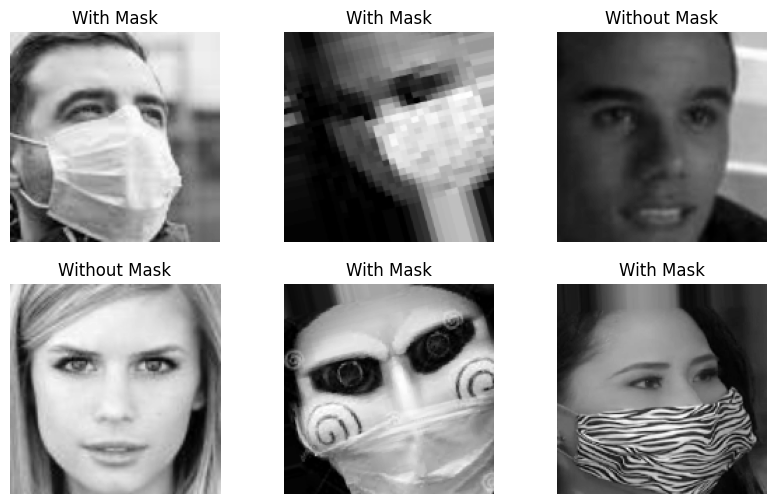

In [24]:
# 그림 확인하기
fig, ax = plt.subplots(2, 3, figsize=(10,6))

for row in range(2):
    for col in range(3):
        image_index = row * 100 + col

        ax[row, col].axis('off')
        ax[row, col].imshow(data[image_index][0], cmap='gray')

        if data[image_index][1] == 0:
            ax[row, col].set_title('Without Mask')
        else:
            ax[row, col].set_title('With Mask')

In [27]:
from tensorflow.keras import layers, models
# 데이터 분할
X = []
y = []

for image in data:
    X.append(image[0])
    y.append(image[1])

X = np.array(X)
y = np.array(y)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=13)

# 모델 생성
model = models.Sequential([
    layers.Conv2D(32, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu', input_shape=(150,150,1)),
    layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    layers.Conv2D(64, (2,2), activation='relu', padding='same'),
    layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(1000, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [28]:
# compile
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [29]:
# shape 조정
X_train = X_train.reshape(-1, 150, 150, 1)
X_val = X_val.reshape(-1, 150, 150, 1)
# 학습
history = model.fit(X_train, y_train, epochs=4, batch_size=32)

Epoch 1/4
250/250 [==============================] - 740s 3s/step - loss: 34.9034 - accuracy: 0.8986
Epoch 2/4
250/250 [==============================] - 627s 3s/step - loss: 0.1394 - accuracy: 0.9705
Epoch 3/4
250/250 [==============================] - 632s 3s/step - loss: 0.0467 - accuracy: 0.9861
Epoch 4/4
250/250 [==============================] - 646s 3s/step - loss: 0.0348 - accuracy: 0.9901


In [30]:
# 모델 평가
model.evaluate(X_val, y_val)

63/63 [==============================] - 26s 414ms/step - loss: 0.1974 - accuracy: 0.9720


[0.1973734349012375, 0.972000002861023]

In [31]:
# 예측 후 평가 지표
prediction = (model.predict(X_val) > 0.5).astype('int32')

print(classification_report(y_val, prediction))
print(confusion_matrix(y_val, prediction))

63/63 [==============================] - 28s 439ms/step
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       955
           1       0.98      0.97      0.97      1045

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000

[[ 932   23]
 [  33 1012]]


In [32]:
# 틀린 값 저장
wrong_result = []

for n in range(0, len(y_val)):
    if prediction[n] != y_val[n]:
        wrong_result.append(n)

len(wrong_result)

56

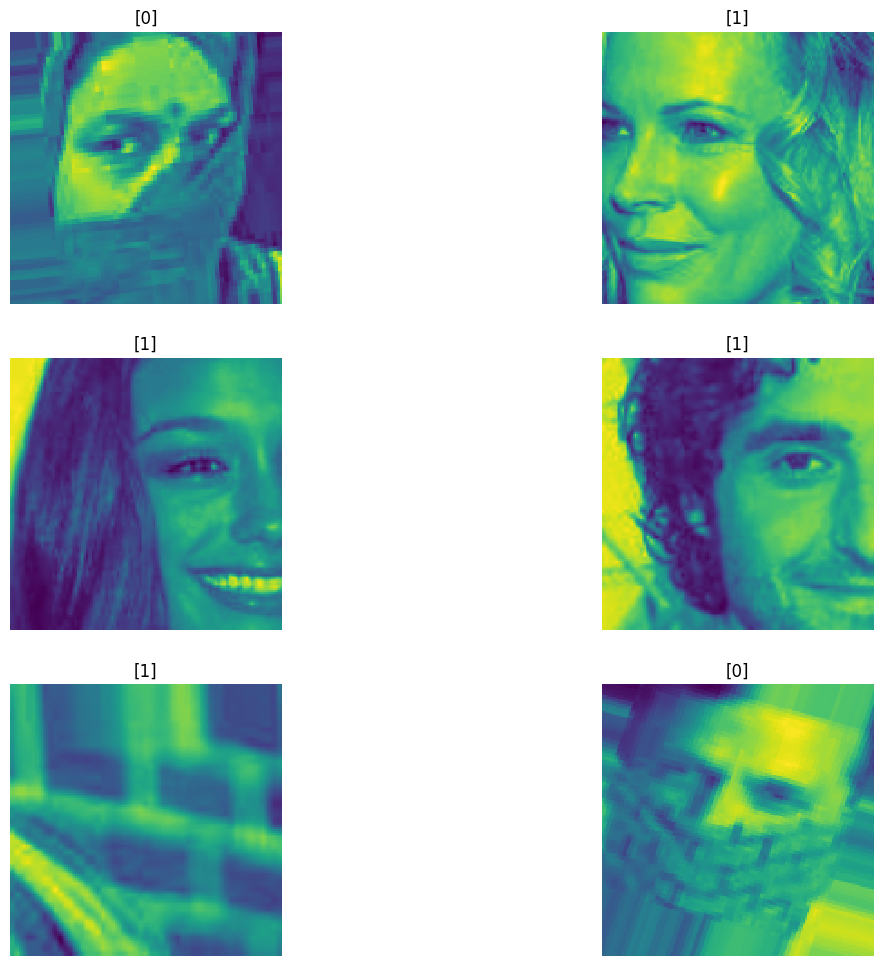

In [33]:
# 틀린 값 확인
import random

samples = random.choices(population=wrong_result, k=6)

plt.figure(figsize=(14,12))

for idx, n in enumerate(samples):
    plt.subplot(3, 2, idx+1)
    plt.imshow(X_val[n].reshape(150,150), interpolation='nearest')
    plt.title(prediction[n])
    plt.axis('off')

plt.show()